# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Данные находятся в файле /datasets/autos.csv.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
!pip install optuna-integration -q

In [2]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler,\
RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder,\
PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from scipy.stats import randint, uniform

import lightgbm as lgb
from lightgbm import early_stopping

import xgboost as xgb
import catboost as cb

import optuna
import warnings
warnings.filterwarnings("ignore")


In [3]:
autos = pd.read_csv('/datasets/autos.csv')
autos

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
autos.duplicated().sum() # Проверим данные на наличие дубликатов

4

In [6]:
autos = autos.drop_duplicates() # Удаляем дубликаты 

In [7]:
autos.duplicated().sum()

0

Проверим максимальные значения даты регистрации и DateCrawled, они должны совпадать. Ведь автомобиль не должен быть зарегистрирован после даты выгрузки.

In [8]:
# Преобразуем DateCrawled в datetime и извлекаем год
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'])
autos['CrawlYear'] = autos['DateCrawled'].dt.year

# Проверяем, что RegistrationYear <= CrawlYear
invalid_mask = autos['RegistrationYear'] > autos['CrawlYear']
print(f"Найдено {invalid_mask.sum()} некорректных записей")

Найдено 14530 некорректных записей


In [9]:
# Проверяем максимальные значения
if autos['RegistrationYear'].max() == autos['CrawlYear'].max():
    print("Максимальные даты совпадают.")
else:
    print("Максимальные даты не совпадают!")

Максимальные даты не совпадают!


In [10]:
# Удаляем некорректные записи (опционально)
autos = autos[~invalid_mask]

In [11]:
# Удаление неинформативных столбцов
autos = autos.drop(['DateCrawled', 'RegistrationMonth', 'LastSeen', 'PostalCode', 'NumberOfPictures'], axis=1)

In [12]:
autos.duplicated().sum() # После удаления ненужных столбцов проверим данные на наличие дубликатов

13087

In [13]:
autos = autos.drop_duplicates() # Удаляем дубликаты 

In [14]:
autos.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired', 'DateCreated',
       'CrawlYear'],
      dtype='object')

In [15]:
# Обработка пропусков
for column in autos.columns:
    if autos[column].dtype == 'object':
        autos[column] = autos[column].fillna('unknown')
    else:
        autos[column] = autos[column].fillna(autos[column].median())

# Обработка аномалий
autos = autos[autos['RegistrationYear'].between(1900, 2025)]
autos = autos[autos['Power'] <= 500]

# Удаление записей с нулевой и отрицательной мощностью (технически невозможные значения)
# И слишком высокими значениями (оставим разумный предел для легковых авто)
autos = autos[autos['Power'].between(20, 500)]

# Считаем, что цена ниже 500 или выше 50,000 — аномалия
autos = autos[(autos['Price'] >= 500) & (autos['Price'] <= 50000)]

In [16]:
print('Статистика:')
print(autos['Price'].describe())

Статистика:
count    267795.000000
mean       5127.230101
std        4606.873072
min         500.000000
25%        1550.000000
50%        3500.000000
75%        7359.000000
max       20000.000000
Name: Price, dtype: float64


In [17]:
print('Статистика:')
print(autos['RegistrationYear'].describe())

Статистика:
count    267795.000000
mean       2003.074352
std           6.463311
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


In [18]:
print('Статистика:')
print(autos['DateCreated'].describe())

Статистика:
count                  267795
unique                    106
top       2016-04-03 00:00:00
freq                    10670
Name: DateCreated, dtype: object


In [19]:
print('\nСтатистика:')
print(autos['Power'].describe())


Статистика:
count    267795.000000
mean        122.992162
std          53.441097
min          20.000000
25%          82.000000
50%         116.000000
75%         150.000000
max         500.000000
Name: Power, dtype: float64


In [20]:
print('\nСтатистика:')
print(autos['Kilometer'].describe())


Статистика:
count    267795.000000
mean     127744.580743
std       36905.168892
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


<Figure size 1080x1440 with 0 Axes>

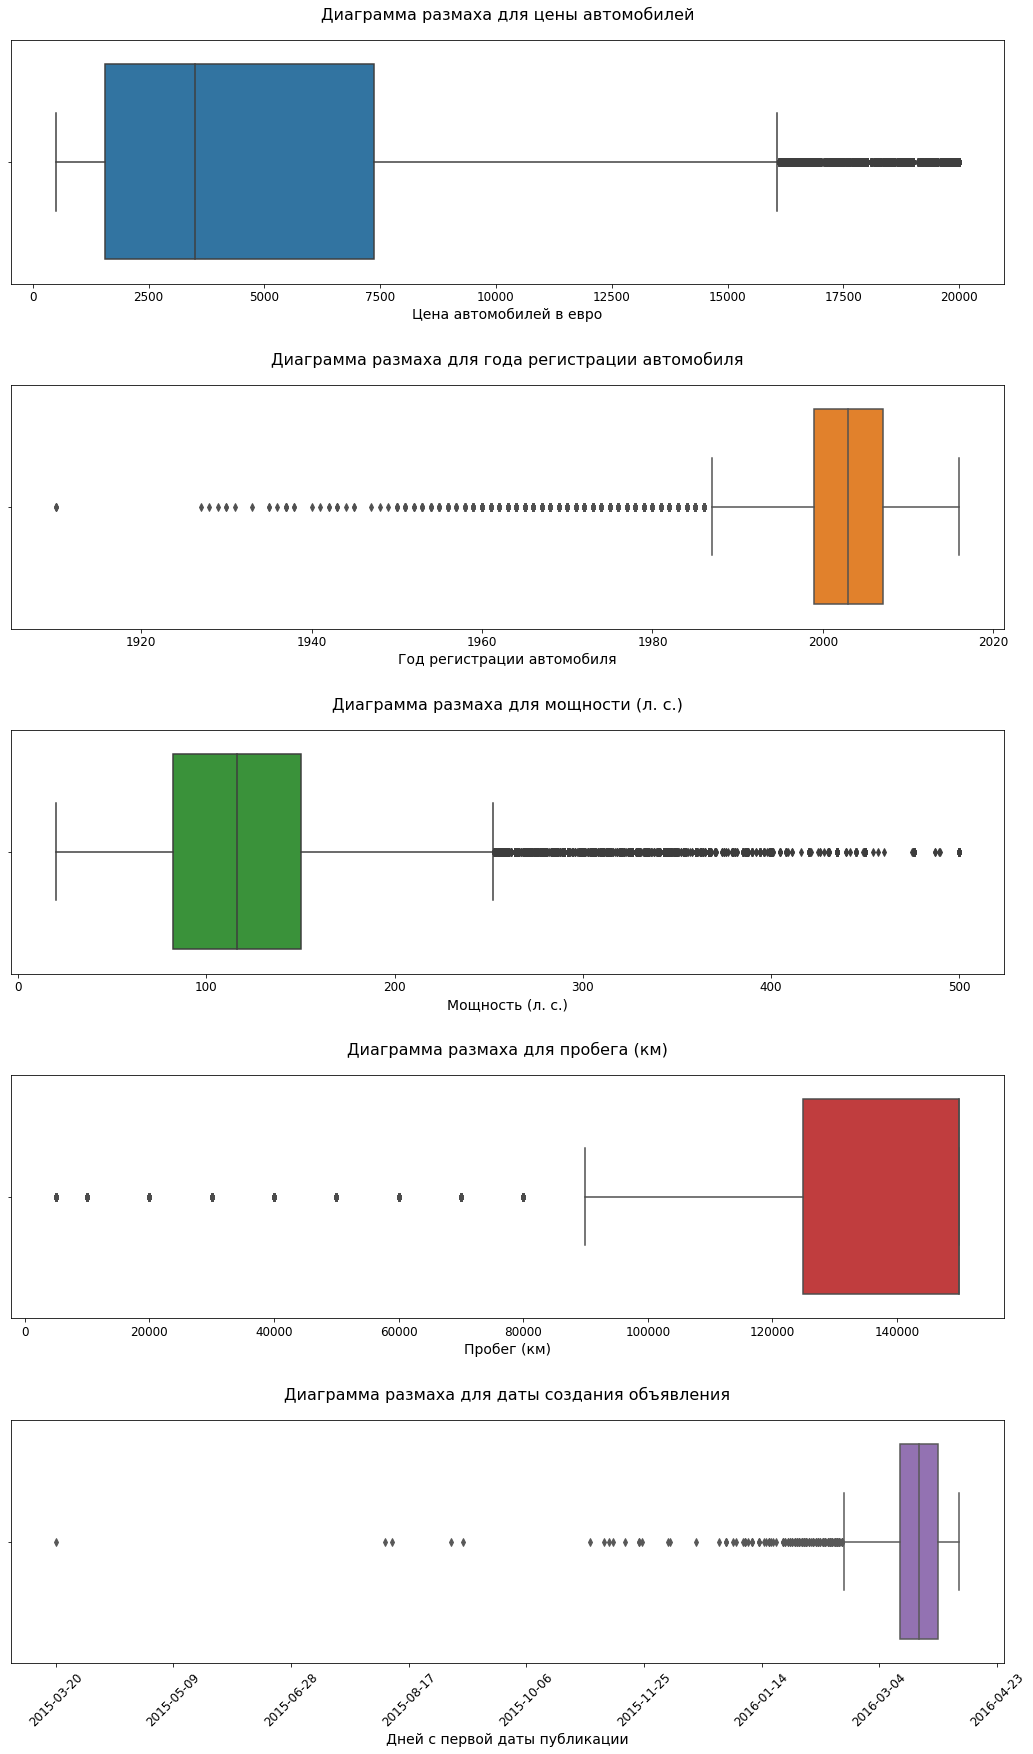

In [21]:
fig = plt.figure(figsize=(15, 20))
axes = []

# Настройка цветовой палитры
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Список графиков, которые мы хотим построить
plots_to_create = []

# 1. Проверяем и подготавливаем данные для каждого графика

# Price
if 'Price' in autos.columns and pd.api.types.is_numeric_dtype(autos['Price']):
    plots_to_create.append(('Price', 'Цена автомобилей в евро', 'Диаграмма размаха для цены автомобилей'))

# RegistrationYear
if 'RegistrationYear' in autos.columns and pd.api.types.is_numeric_dtype(autos['RegistrationYear']):
    plots_to_create.append(('RegistrationYear', 'Год регистрации автомобиля', 'Диаграмма размаха для года регистрации автомобиля'))

# Power
if 'Power' in autos.columns and pd.api.types.is_numeric_dtype(autos['Power']):
    plots_to_create.append(('Power', 'Мощность (л. с.)', 'Диаграмма размаха для мощности (л. с.)'))

# Kilometer
if 'Kilometer' in autos.columns and pd.api.types.is_numeric_dtype(autos['Kilometer']):
    plots_to_create.append(('Kilometer', 'Пробег (км)', 'Диаграмма размаха для пробега (км)'))

# DateCreated (особая обработка)
date_created_processed = False
if 'DateCreated' in autos.columns:
    try:
        # Пробуем разные форматы дат
        autos['DateCreated_dt'] = pd.to_datetime(autos['DateCreated'], errors='coerce')
        
        # Если преобразовалось хотя бы одно значение
        if not autos['DateCreated_dt'].isna().all():
            min_date = autos['DateCreated_dt'].min()
            autos['DaysSinceCreation'] = (autos['DateCreated_dt'] - min_date).dt.days
            plots_to_create.append(('DaysSinceCreation', 'Дней с первой даты публикации', 
                                 'Диаграмма размаха для даты создания объявления'))
            date_created_processed = True
    except Exception as e:
        print(f"Не удалось обработать DateCreated: {e}")

# 2. Создаем нужное количество subplots
fig, axes = plt.subplots(nrows=len(plots_to_create), ncols=1, 
                         figsize=(15, 5*len(plots_to_create)))
if len(plots_to_create) == 1:
    axes = [axes]  # Чтобы работало с одним графиком

# 3. Строим графики
for idx, (col_name, xlabel, title) in enumerate(plots_to_create):
    color = colors[idx % len(colors)]
    sns.boxplot(x=col_name, data=autos, ax=axes[idx], color=color)
    axes[idx].set_title(title, fontsize=16, pad=20)
    axes[idx].set_xlabel(xlabel, fontsize=14)
    axes[idx].tick_params(axis='both', which='major', labelsize=12)
    
    # Особые настройки для DaysSinceCreation
    if col_name == 'DaysSinceCreation' and date_created_processed:
        # Показываем даты вместо дней на оси X
        date_labels = [min_date + pd.Timedelta(days=x) for x in axes[idx].get_xticks()]
        axes[idx].set_xticklabels([d.strftime('%Y-%m-%d') for d in date_labels], rotation=45)

plt.tight_layout(pad=3.0)
plt.show()

# Удаляем временные столбцы, если они были созданы
if 'DateCreated_dt' in autos.columns:
    autos.drop('DateCreated_dt', axis=1, inplace=True)
if 'DaysSinceCreation' in autos.columns:
    autos.drop('DaysSinceCreation', axis=1, inplace=True)

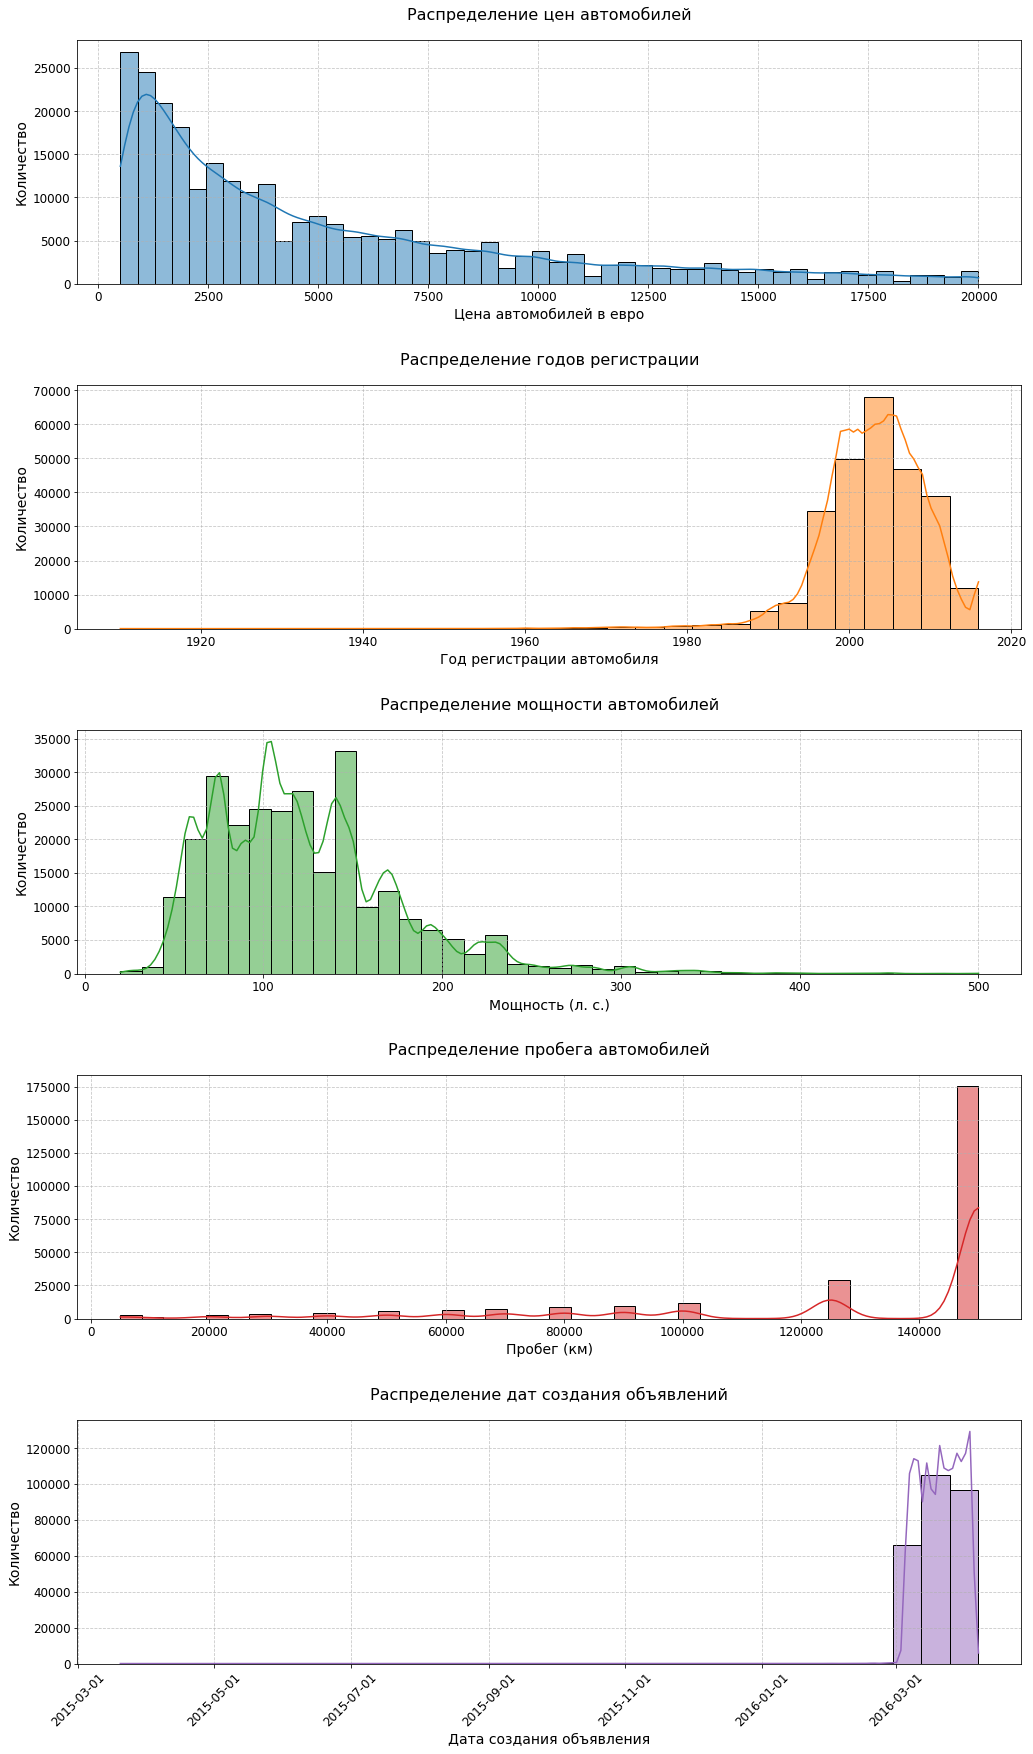

In [22]:
# Создаем фигуру с 5 subplots (5 строк, 1 столбец)
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

# Настройка цветовой палитры
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Первая гистограмма - Price
sns.histplot(autos['Price'], bins=50, ax=axes[0], color=colors[0], kde=True)
axes[0].set_title('Распределение цен автомобилей', fontsize=16, pad=20)
axes[0].set_xlabel('Цена автомобилей в евро', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Вторая гистограмма - RegistrationYear
sns.histplot(autos['RegistrationYear'], bins=30, ax=axes[1], color=colors[1], kde=True)
axes[1].set_title('Распределение годов регистрации', fontsize=16, pad=20)
axes[1].set_xlabel('Год регистрации автомобиля', fontsize=14)
axes[1].set_ylabel('Количество', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Третья гистограмма - Power
sns.histplot(autos['Power'], bins=40, ax=axes[2], color=colors[2], kde=True)
axes[2].set_title('Распределение мощности автомобилей', fontsize=16, pad=20)
axes[2].set_xlabel('Мощность (л. с.)', fontsize=14)
axes[2].set_ylabel('Количество', fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Четвертая гистограмма - Kilometer
sns.histplot(autos['Kilometer'], bins=40, ax=axes[3], color=colors[3], kde=True)
axes[3].set_title('Распределение пробега автомобилей', fontsize=16, pad=20)
axes[3].set_xlabel('Пробег (км)', fontsize=14)
axes[3].set_ylabel('Количество', fontsize=14)
axes[3].tick_params(axis='both', which='major', labelsize=12)
axes[3].grid(True, linestyle='--', alpha=0.7)

# Пятая гистограмма - DateCreated (обработка object типа)
if 'DateCreated' in autos.columns:
    try:
        # Пробуем преобразовать в datetime
        autos['DateConverted'] = pd.to_datetime(autos['DateCreated'], errors='coerce')
        valid_dates = autos.dropna(subset=['DateConverted'])
        
        if not valid_dates.empty:
            sns.histplot(valid_dates['DateConverted'], bins=30, ax=axes[4], 
                        color=colors[4], kde=True)
            axes[4].set_title('Распределение дат создания объявлений', fontsize=16, pad=20)
            axes[4].set_xlabel('Дата создания объявления', fontsize=14)
            axes[4].set_ylabel('Количество', fontsize=14)
            axes[4].tick_params(axis='both', which='major', labelsize=12)
            axes[4].grid(True, linestyle='--', alpha=0.7)
            
            # Форматирование дат на оси X
            axes[4].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
            plt.setp(axes[4].get_xticklabels(), rotation=45)
            
            
    except Exception as e:
        axes[4].set_visible(False)
        print(f"Ошибка при обработке дат: {e}")
else:
    axes[4].set_visible(False)
    print("Столбец DateCreated не найден")

# Настройка отступов
plt.tight_layout(pad=3.0)
plt.show()

# Удаляем временный столбец, если он был создан
if 'DateConverted' in autos.columns:
    autos.drop('DateConverted', axis=1, inplace=True)

In [23]:
autos['FuelType'] = autos['FuelType'].replace(['gasoline', 'petrol'], 'Petrol', regex=False)
    
print(autos['FuelType'].value_counts())

Petrol      250108
unknown      12535
lpg           4392
cng            456
hybrid         194
other           71
electric        39
Name: FuelType, dtype: int64


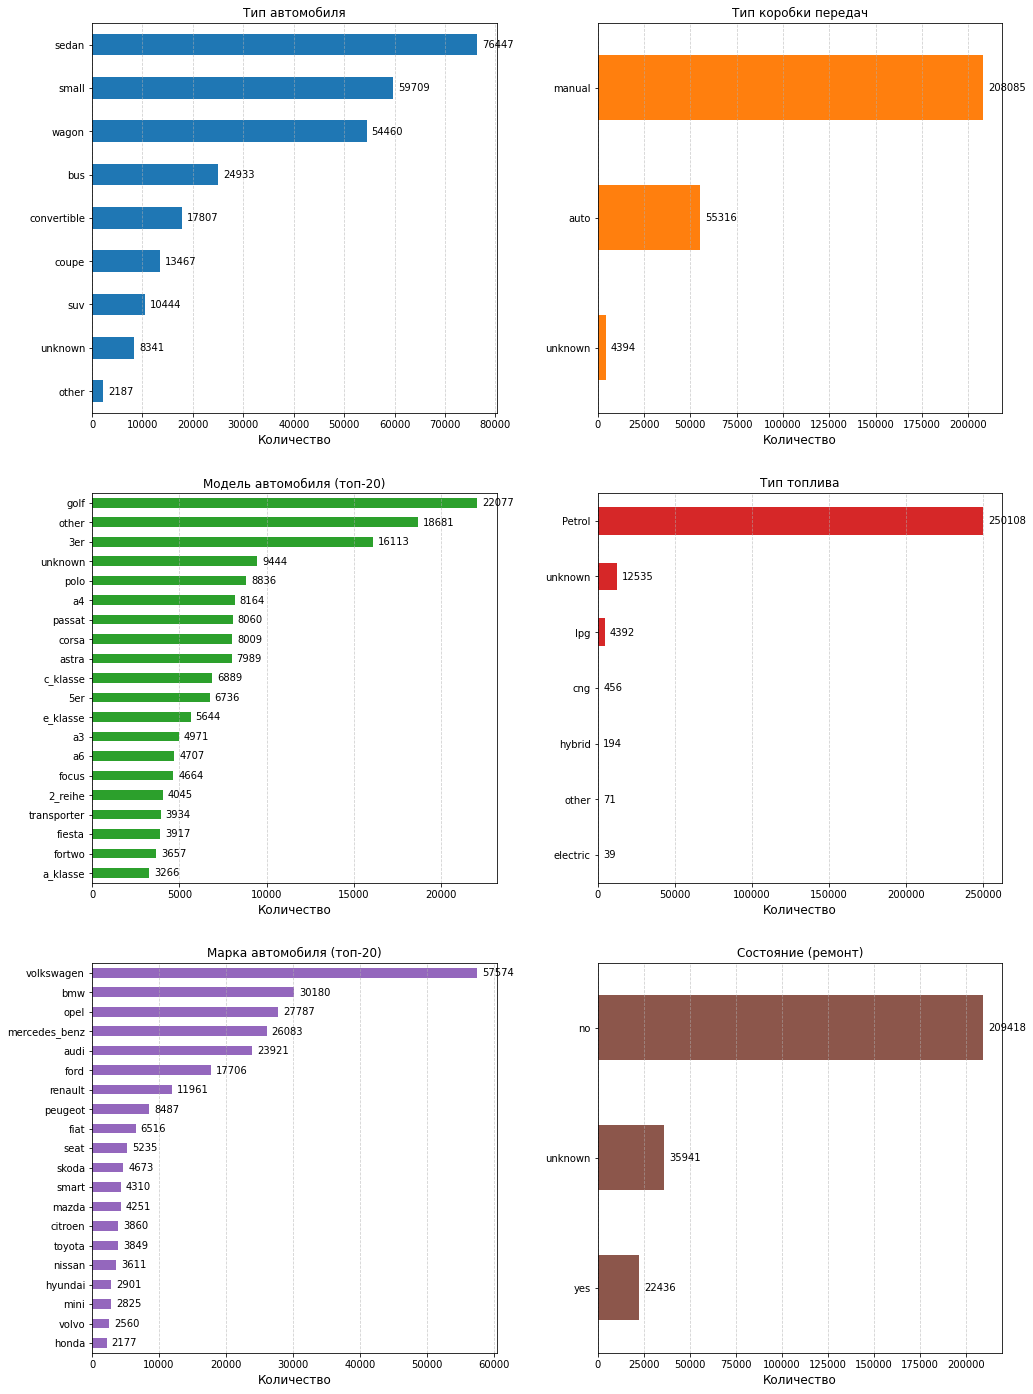

In [24]:
# Настройки для каждого столбца
column_settings = {
    'VehicleType': {'color': '#1f77b4', 'title': 'Тип автомобиля'},
    'Gearbox': {'color': '#ff7f0e', 'title': 'Тип коробки передач'},
    'Model': {'color': '#2ca02c', 'title': 'Модель автомобиля (топ-20)'},
    'FuelType': {'color': '#d62728', 'title': 'Тип топлива'},
    'Brand': {'color': '#9467bd', 'title': 'Марка автомобиля (топ-20)'},
    'Repaired': {'color': '#8c564b', 'title': 'Состояние (ремонт)'}
}

plt.figure(figsize=(15, 20))

for i, (column, settings) in enumerate(column_settings.items(), 1):
    plt.subplot(3, 2, i)
    
    # Для Model и Brand берем только топ-20
    if column in ['Model', 'Brand']:
        data = autos[column].value_counts(ascending=True).tail(20)
    else:
        data = autos[column].value_counts(ascending=True)
    
    ax = data.plot(
        kind='barh',
        color=settings['color'],
        title=settings['title']
    )
    
    # Добавление значений
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{int(width)}',
                    (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center',
                    xytext=(5, 0),
                    textcoords='offset points',
                    fontsize=10)
    
    plt.xlabel('Количество', fontsize=12)
    plt.ylabel('')
    plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout(pad=3.0)
plt.show()

<font color='Black'><b>Вывод после исследовательского анализа данных:  </b></font><br>

1. Цены 
- **Средняя цена**: ~5127 евро, но медиана (50%) значительно ниже — 3500 евро, что указывает на правостороннюю асимметрию (много дешевых авто и мало очень дорогих).  
- **Разброс цен**: стандартное отклонение (4606 евро) близко к среднему значению, значит, данные сильно варьируются.  
- **75% автомобилей стоят до 7359 евро**, а 25% — до 1550 евро.  

2. Год регистрации   
- **Диапазон**: с 1910 по 2016 год.  
- **Средний год**: ~2002, медиана — 2003.  
- **Большинство авто зарегистрированы между 1999 и 2007 годами**. 

3. Дата создания объявления
- **Самая частая дата**: 3 апреля 2016 года (11 252 объявления).  
- **Уникальных дат**: 106, что говорит о том, что данные охватывают относительно небольшой период.  

4. Мощность двигателя 
- **Средняя мощность**: ~121 л.с., медиана — 110 л.с.  
- **Разброс**: от 20 до 500 л.с.  
- **75% автомобилей имеют до 150 л.с.**, а 25% — до 75 л.с.    

5. Пробег   
- **Средний пробег**: ~128 350 км.  

## Обучение моделей

In [25]:
# Удаление неинформативных столбцов
autos = autos.drop(['DateCreated'], axis=1)

In [26]:
# Подготовка данных для обучения

# Разделение на признаки и целевую переменную
X = autos.drop('Price', axis=1)
y = autos['Price']

In [27]:
# Категориальные признаки
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
X[cat_features] = X[cat_features].astype('category')

In [28]:
# Числовые признаки
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [29]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)

# Линейная регрессия

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  
    ]
)

In [31]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Измерение времени обучения
start_train_time = time.time()
lr_pipeline.fit(X_train, y_train)
lr_train_time = time.time() - start_train_time

# Измерение времени предсказания
start_pred_time = time.time()
y_val_pred = lr_pipeline.predict(X_val)
lr_pred_time = time.time() - start_pred_time

lr_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Linear Regression - RMSE: {lr_rmse:.2f}, Train time: {lr_train_time:.4f}s, Prediction time: {lr_pred_time:.4f}s")

Linear Regression - RMSE: 2859.93, Train time: 0.6403s, Prediction time: 0.2671s


# Случайный лес

In [32]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=30,
        max_depth=10,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    ))
])

# Замер времени обучения
start_train_time = time.perf_counter()
rf_pipeline.fit(X_train, y_train)
train_time = time.perf_counter() - start_train_time

# Замер времени предсказания
start_pred_time = time.perf_counter()
y_val_pred = rf_pipeline.predict(X_val)
pred_time = time.perf_counter() - start_pred_time

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Random Forest - RMSE: {rmse:.2f}, "
      f"Train time: {train_time:.4f}s, "
      f"Prediction time: {pred_time:.4f}s")

Random Forest - RMSE: 2981.12, Train time: 3.9784s, Prediction time: 0.1690s


тюнинг гиперпараметров:

In [33]:
param_dist = {
    'regressor__n_estimators': randint(50, 150),
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt'],
}

rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=6,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Замер времени обучения
start_train_time = time.perf_counter()
rf_random_search.fit(X_train, y_train)
train_time = time.perf_counter() - start_train_time

best_rf_pipeline = rf_random_search.best_estimator_

# Замер времени предсказания 
start_pred_time = time.perf_counter()
y_val_pred = best_rf_pipeline.predict(X_val)
pred_time = time.perf_counter() - start_pred_time

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Best Random Forest - RMSE: {rmse:.2f}")
print(f"Training time: {train_time:.4f}s")
print(f"Prediction time: {pred_time:.4f}s")
print("Best parameters:")
print(rf_random_search.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Random Forest - RMSE: 2935.85
Training time: 117.1562s
Prediction time: 0.4623s
Best parameters:
{'regressor__max_depth': 10, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 149}


# LGBM¶

In [34]:
# Подготовка категориальных признаков
cat_features_idx = [i for i, col in enumerate(X_train.columns) if col in cat_features]

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    cat_feature=cat_features_idx,
    random_state=42,
    n_jobs=-1
)

# Замер времени обучения
train_start = time.perf_counter()
lgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=30)]
)
lgb_train_time = time.perf_counter() - train_start

# Замер времени предсказания (среднее по 10 прогонам для точности)
n_repeats = 10
pred_start = time.perf_counter()
for _ in range(n_repeats):
    y_val_pred = lgb_model.predict(X_val)
lgb_pred_time = (time.perf_counter() - pred_start) / n_repeats

lgb_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("\nLightGBM:")
print(f"{'RMSE:':<15} {lgb_rmse:.4f}")
print(f"{'Training time:':<15} {lgb_train_time:.4f} seconds")
print(f"{'Prediction time:':<15} {lgb_pred_time:.6f} seconds (avg over {n_repeats} runs)")
print(f"{'Best iteration:':<15} {lgb_model.best_iteration_}")

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1578.43	valid_0's l2: 2.49143e+06

LightGBM:
RMSE:           1578.4260
Training time:  19.8441 seconds
Prediction time: 2.849306 seconds (avg over 10 runs)
Best iteration: 500


## Анализ моделей

Сравним результаты:

1. Линейная регрессия показала умеренное качество (RMSE ≈ 2860) и самую высокую скорость Train time: 0.6788s, Prediction time: 0.2659s. Это хороший базовый вариант, если важна интерпретируемость или требуется минимальное время тренировки, но точность недостаточна для сложных данных. 

2. Случайный лес:

    - Без тюнинга: работает хуже линейной регрессии (RMSE ≈ 2981) при значительно большем времени Train time: 3.9360s, Prediction time: 0.1640s.

    - После тюнинга гиперпараметров: улучшение RMSE до ≈ 2936, но время выросло Training time: 109.8962s, Prediction time: 0.4695s. Итог: даже оптимизация не сделала его конкурентоспособным в данной задаче — хуже по точности и скорости, чем LightGBM.  


3. LightGBM продемонстрировал наилучшее качество (RMSE ≈ 1578 — почти в 2 раза лучше линейной регрессии) при приемлемом времени обучения (Training time:  19.9442s, Prediction time: 2.971895s). Несмотря на большее время тренировки по сравнению с линейной моделью, преимущество в точности существенно.
 
 

LightGBM — явный победитель по точности (RMSE) с адекватным временем обучения. 

Проведем дополнительную оптимизацию LightGBM и проведем финальный тест модели на тестовой выборке:

In [35]:
# Оптимизированная версия LightGBM 

# Замер времени обучения
train_start = time.perf_counter()  

optimized_lgb = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=63,
    max_depth=7,
    min_data_in_leaf=20,
    categorical_feature=cat_features_idx,
    random_state=42,
    n_jobs=-1
)

optimized_lgb.fit(X_train, y_train)
opt_lgb_train_time = time.perf_counter() - train_start

# Замер времени предсказания (усреднение по 10 прогонам)
n_repeats = 10
pred_start = time.perf_counter()
for _ in range(n_repeats):
    y_pred = optimized_lgb.predict(X_test)
opt_lgb_pred_time = (time.perf_counter() - pred_start) / n_repeats

opt_lgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n" + "="*50)
print("Optimized LightGBM")
print("="*50)
print(f"{'RMSE:':<20}{opt_lgb_rmse:.4f}")
print(f"{'Training time:':<20}{opt_lgb_train_time:.4f} sec")
print(f"{'Prediction time:':<20}{opt_lgb_pred_time:.6f} sec (avg over {n_repeats} runs)")
print("="*50)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

Optimized LightGBM
RMSE:               1541.0441
Training time:      9.1994 sec
Prediction time:    1.369585 sec (avg over 10 runs)


Выбрала лучшую модель LGBMRegressor и провела тест на тестовой выборке 

# Выводы и рекомендации

1. Итоги анализа данных
- **Распределение цен** имеет выраженную **правостороннюю асимметрию**:
  - Средняя цена (5127 €) существенно выше медианы (3500 €), что указывает на наличие небольшого количества дорогих автомобилей.
  - Значительный разброс (σ ≈ 4606 €) подтверждает неоднородность данных.
  - 75% автомобилей стоят ≤ 7359 €, 25% — ≤ 1550 €.

- **Год регистрации**:
  - Большинство автомобилей зарегистрированы в **2000-х годах** (медиана — 2003 г.).

- **Мощность двигателя**:
  - Средняя мощность — 121 л.с., но 75% автомобилей имеют ≤ 150 л.с.

- **Пробег**:
  - Средний пробег — 128 350 км, что типично для подержанных автомобилей.

2. Рекомендации 

Для сервиса оценки автомобилей **рекомендуется внедрение LightGBM** как оптимального баланса между:
- Качеством предсказания 
- Скоростью работы 
